In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO

In [2]:
# Initialize S3 client
s3 = boto3.client('s3')

# Function to load data 
bucket_name = 'ml-stack-759578648427-us-west-2'

def from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    ext = os.path.splitext(file_name)[1]
    if ext == '.gz':
        data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')
    elif ext == '.csv':
        data = pd.read_csv(BytesIO(response['Body'].read()))
    else:
        data = pd.read_excel(BytesIO(response['Body'].read()), sheet_name='DX_to_CCSR_Mapping', header=1)
    return data

# Import Modeling Set

In [3]:
file_name = 'MIMIC/Cleaned/df_omr_pt_ad.csv'
df = from_s3(bucket_name, file_name) 
df['charttime'] = pd.to_datetime(df['charttime'])
subjects = df['subject_id'].unique()
df.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age,insurance,language,marital_status,race
0,10000826,2146-12-08 22:22:00,NaN,NaN,NaN,NaN,F,32,Private,English,SINGLE,WHITE
1,10000898,2187-09-26 08:00:00,NaN,NaN,126.000,76.000,F,79,NaN,NaN,NaN,NaN
2,10000980,2185-10-24 00:00:00,NaN,173.000,150.000,90.000,F,72,NaN,NaN,NaN,NaN
3,10001122,2142-04-08 10:48:00,NaN,NaN,NaN,NaN,F,70,NaN,NaN,NaN,NaN
4,10001401,2133-12-15 11:04:00,65.450,167.941,146.537,60.630,F,91,Medicare,English,MARRIED,WHITE


# + Diagnosis

Use ICD 9 to 10 crosswalk from: https://github.com/JeanNikiema/mimicinicd11/tree/main

Use broad category map from: https://hcup-us.ahrq.gov/toolssoftware/ccsr/dxccsr.jsp

In [4]:
file_name = 'MIMIC/Cleaned/icd_code_map.csv'
icd_code_map = from_s3(bucket_name, file_name) 

file_name = 'MIMIC/admissions.csv.gz'
ad = from_s3(bucket_name, file_name) 

file_name = 'MIMIC/diagnoses_icd.csv.gz'
diag = from_s3(bucket_name, file_name) 

# filter to possible patients only
diag = diag[diag['subject_id'].isin(subjects)]

# join addmission to get discharge time - prevent data leakage
diag = diag.merge(ad[['subject_id', 'hadm_id', 'dischtime']], on=['subject_id', 'hadm_id'], how='left')
del ad

# merge icd_code_mapping
diag_mapped = diag.merge(icd_code_map, on='icd_code', how='left')
del diag

# % matched
matched = diag_mapped[~diag_mapped.ccsr_category.isna()]
num_matched = diag_mapped[~diag_mapped.ccsr_category.isna()].icd_code.nunique() / diag_mapped.icd_code.nunique()
print(f"Matched {num_matched:.2%} codes")

# keep broad codes only
diag_mapped = diag_mapped[['subject_id', 'dischtime', 'ccsr_category']].drop_duplicates()
# fill diag_mapped ccsr_category with 99
diag_mapped.ccsr_category.fillna(99, inplace=True)
diag_mapped.head()

Matched 98.49% codes


/tmp/ipykernel_164/4126125017.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diag_mapped.ccsr_category.fillna(99, inplace=True)


,subject_id,dischtime,ccsr_category
0,10000826,2146-12-12 16:30:00,DIG019
1,10000826,2146-12-12 16:30:00,MBD017
2,10000826,2146-12-12 16:30:00,RSP002
3,10000826,2146-12-12 16:30:00,SYM006
5,10000826,2146-12-12 16:30:00,GEN004


In [5]:
diag_pivot = diag_mapped.groupby(['subject_id', 'dischtime', 'ccsr_category']).size().reset_index()
diag_pivot = diag_pivot.pivot(index=['subject_id', 'dischtime'], columns='ccsr_category', values=0).reset_index()
diag_pivot.fillna(0, inplace=True)
diag_pivot.head()

ccsr_category,subject_id,dischtime,99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,...,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018
0,10000826,2146-12-12 16:30:00,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,10000826,2146-12-24 19:55:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10000826,2147-01-02 17:45:00,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,10000980,2188-01-05 17:30:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,10000980,2189-07-03 03:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [6]:
# merge to sub/charttime data set
sub_time = df[['subject_id', 'charttime']].drop_duplicates()
df_diag = sub_time.merge(diag_pivot, on=['subject_id'], how='left')

# filter disch less than chartime
df_diag['dischtime'] = pd.to_datetime(df_diag['dischtime'])
df_diag['charttime'] = pd.to_datetime(df_diag['charttime'])
df_diag = df_diag[(df_diag.dischtime <= df_diag.charttime) | (df_diag.dischtime.isna() == True)]

# drop disch
df_diag.drop(columns=['dischtime'], inplace=True)

# count all diagnoses in medical hisotry up to charttime
df_diag = df_diag.groupby(['subject_id', 'charttime']).sum().reset_index()
df_diag.fillna(0, inplace=True)
df_diag.head()

,subject_id,charttime,99,BLD001,BLD002,BLD003,BLD004,BLD005,BLD006,BLD007,...,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018
0,10000898,2187-09-26 08:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,10001122,2142-04-08 10:48:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10001401,2133-12-15 11:04:00,0.000,1.000,0.000,1.000,2.000,0.000,0.000,1.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000
3,10001401,2134-10-09 13:45:00,0.000,1.000,0.000,1.000,2.000,0.000,0.000,1.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000
4,10001401,2135-09-20 13:04:00,0.000,1.000,0.000,1.000,2.000,0.000,0.000,1.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000


In [7]:
# join to final data set 
df_omr_pt_ad_diag = df.merge(df_diag, on=['subject_id', 'charttime'], how='left')
df_omr_pt_ad_diag.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age,insurance,language,...,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018
0,10000826,2146-12-08 22:22:00,NaN,NaN,NaN,NaN,F,32,Private,English,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000898,2187-09-26 08:00:00,NaN,NaN,126.000,76.000,F,79,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10000980,2185-10-24 00:00:00,NaN,173.000,150.000,90.000,F,72,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001122,2142-04-08 10:48:00,NaN,NaN,NaN,NaN,F,70,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,10001401,2133-12-15 11:04:00,65.450,167.941,146.537,60.630,F,91,Medicare,English,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000


In [9]:
df_omr_pt_ad_diag.describe()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age,99,BLD001,BLD002,...,SYM009,SYM010,SYM011,SYM012,SYM013,SYM014,SYM015,SYM016,SYM017,SYM018
count,44918.000,44918,24804.000,29227.000,28069.000,28069.000,44918.000,30209.000,30209.000,30209.000,...,30209.000,30209.000,30209.000,30209.000,30209.000,30209.000,30209.000,30209.000,30209.000,30209.000
mean,15008362.972,2155-11-13 19:40:29.742196736,64.923,355.784,128.353,72.774,64.246,1.192,0.339,0.030,...,0.000,0.268,0.313,0.249,0.365,0.074,0.059,0.333,0.486,0.009
min,10000826.000,2109-03-19 11:40:00,0.000,0.000,70.000,8.000,17.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,12495580.500,2135-12-22 12:53:30,62.000,140.000,118.227,67.000,53.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,15002051.500,2155-11-02 22:04:30,64.580,166.767,128.125,72.500,67.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,17544474.250,2175-11-29 19:46:00,67.600,201.170,137.667,78.500,79.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
max,19999987.000,2214-12-24 05:14:00,363.000,1781921.394,236.000,135.000,106.000,51.000,40.000,27.000,...,1.000,43.000,24.000,21.000,30.000,8.000,10.000,26.000,32.000,7.000
std,2893254.342,NaN,5.906,17764.632,14.708,9.076,19.028,2.791,1.414,0.437,...,0.014,0.809,0.978,0.761,1.069,0.333,0.308,0.959,1.249,0.131


# + Prescriptions

Mapping from: https://github.com/fabkury/n2c/tree/main

In [17]:
file_name = 'MIMIC/prescriptions.csv.gz'
pr = from_s3(bucket_name, file_name) 
# filter subjects 
pr = pr[pr['subject_id'].isin(subjects)]
# subset columns 
pr = pr[['subject_id', 'starttime', 'stoptime', 'drug_type', 'drug','formulary_drug_cd','gsn', 'ndc', 'dose_val_rx', 'dose_unit_rx']]
pr.head()

/tmp/ipykernel_164/1980421374.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
370,10000826,20032235,497498,10000826-26,26.000,P4645I,2146-12-06 00:00:00,2146-12-06 08:00:00,MAIN,Morphine Sulfate,...,004072,409125830.000,4mg Syringe,NaN,2-4,mg,0.5-1,SYR,NaN,IV
371,10000826,20032235,1009039,10000826-31,31.000,P4645I,2146-12-06 06:00:00,2146-12-06 08:00:00,MAIN,Lorazepam,...,003753,409198530.000,2mg/mL Syringe,NaN,0.5,mg,0.25,mL,1.000,IV
372,10000826,20032235,1499357,10000826-21,21.000,P4645I,2146-12-05 20:00:00,2146-12-06 08:00:00,MAIN,Heparin,...,006549,63323026201.000,5000 Units / mL- 1mL Vial,NaN,5000,UNIT,1,mL,3.000,SC
373,10000826,20032235,3414803,10000826-90,90.000,P05Y4A,2146-12-07 17:00:00,2146-12-12 21:00:00,MAIN,Docusate Sodium,...,003009,904224461.000,100mg Capsule,NaN,100,mg,1,CAP,NaN,PO
374,10000826,20032235,4081682,10000826-79,79.000,P494U8,2146-12-07 03:00:00,2146-12-08 02:00:00,MAIN,OxycoDONE (Immediate Release),...,004225,406055262.000,5mg Tablet,NaN,2.5,mg,0.5,TAB,1.000,PO/NG


In [56]:
# import ndc to atc4 mapping 
file_name = 'MIMIC/package_NDC_ATC4_classes.csv'
ndc_map = from_s3(bucket_name, file_name) 
# format codes 
ndc_map.NDC = ndc_map.NDC.str.replace('-', '').astype(float)
# join ATC codes to pr 
pr = pr.merge(ndc_map, left_on='ndc', right_on='NDC', how='left')
# fillna 
pr.ATC_class = pr.ATC_class.fillna('99')
# get drug count by stop time 
pr = pr.groupby(['subject_id', 'stoptime', 'ATC_class']).size().reset_index()
#pivot data 
pr = pr.pivot(index=['subject_id', 'stoptime'], columns='ATC_class', values=0).reset_index()
# filna
pr.fillna(0, inplace=True)

,NDC,ATC_class
0,5041942208.000,G02BA
1,6362989791.000,A01AD
2,573016025.000,M01AE
3,5334500401.000,S01GA
4,2504775201.000,R02AD


In [77]:
# join to final data 
df_sub = df[['subject_id', 'charttime']]
df_pr = df_sub.merge(pr, on='subject_id', how='left')
# filter dates, stop time before or equal to charttime 
df_pr['stoptime'] = pd.to_datetime(df_pr['stoptime'])
df_pr = df_pr[(df_pr.stoptime <= df_pr.charttime) | (df_pr.stoptime.isna() == True)]
df_pr.drop(columns=['stoptime'], inplace=True)

# count all presciption counts per category up to charttime i.e., mdeication history 
df_pr = df_pr.groupby(['subject_id', 'charttime']).sum().reset_index()
df_pr.fillna(0, inplace=True)

In [88]:
# merge to final data set 
df_omr_pt_ad_diag_pr = df_omr_pt_ad_diag.merge(df_pr, on=['subject_id', 'charttime'])
df_omr_pt_ad_diag_pr.head()

,subject_id,charttime,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age,insurance,language,...,V03AB,V03AC,V03AE,V03AF,V04CA,V04CC,V04CG,V04CX,V06DC,V07AB
0,10000826,2146-12-08 22:22:00,NaN,NaN,NaN,NaN,F,32,Private,English,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1,10000898,2187-09-26 08:00:00,NaN,NaN,126.000,76.000,F,79,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10001122,2142-04-08 10:48:00,NaN,NaN,NaN,NaN,F,70,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,10001401,2133-12-15 11:04:00,65.450,167.941,146.537,60.630,F,91,Medicare,English,...,0.000,0.000,0.000,0.000,9.000,2.000,0.000,0.000,9.000,0.000
4,10001401,2134-10-09 13:45:00,65.500,168.283,146.155,60.552,F,92,Medicare,English,...,0.000,0.000,0.000,0.000,9.000,2.000,0.000,0.000,9.000,0.000


# EDA & Handling Missing Values

array([[<Axes: title={'center': 'subject_id'}>,
        <Axes: title={'center': 'Height (Inches)'}>],
       [<Axes: title={'center': 'Weight (Lbs)'}>,
        <Axes: title={'center': 'bp_systolic'}>],
       [<Axes: title={'center': 'bp_diastolic'}>,
        <Axes: title={'center': 'anchor_age'}>]], dtype=object)

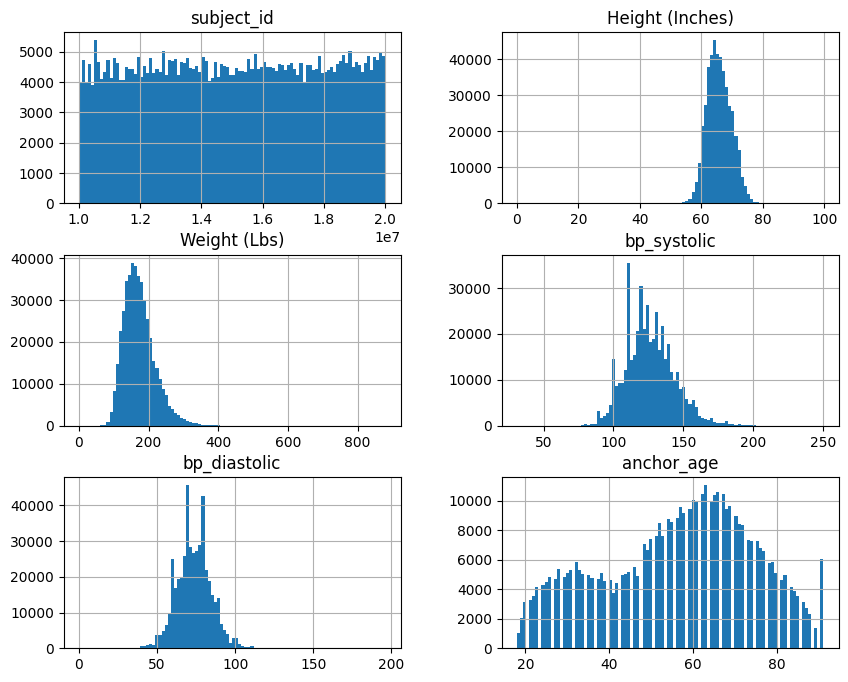

In [ ]:
# distributions
omr_pt.hist(bins=100, figsize=(10, 8))

In [ ]:
# gender counts
omr_pt[['subject_id', 'gender']].drop_duplicates().gender.value_counts()

,count
gender,
F,41722
M,31863


In [ ]:
omr_pt.describe()

,subject_id,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,anchor_age
count,450655.000,450655.000,450655.000,450655.000,450655.000,450655.000
mean,15037081.814,65.622,173.356,126.043,73.726,56.361
std,2894761.886,4.133,45.832,17.503,11.275,17.936
min,10000032.000,0.000,0.000,31.000,0.000,18.000
25%,12542903.000,63.000,140.900,114.000,66.000,43.000
50%,15041265.000,65.333,167.200,124.000,73.500,59.000
75%,17553078.000,68.312,198.000,137.000,80.000,70.000
max,19999828.000,99.700,879.633,250.000,196.000,91.000


In [ ]:
omr_pt.shape

(450655, 9)

In [ ]:
# unqiue patients
omr_pt.subject_id.nunique()

73585

In [ ]:
ad.admission_location.unique()

array(['TRANSFER FROM HOSPITAL', 'EMERGENCY ROOM',
       'WALK-IN/SELF REFERRAL', 'PHYSICIAN REFERRAL', 'PROCEDURE SITE',
       'CLINIC REFERRAL', 'TRANSFER FROM SKILLED NURSING FACILITY',
       'PACU', 'INTERNAL TRANSFER TO OR FROM PSYCH',
       'INFORMATION NOT AVAILABLE', 'AMBULATORY SURGERY TRANSFER', nan],
      dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'TRANSFER FROM HOSPITAL'),
  Text(1, 0, 'EMERGENCY ROOM'),
  Text(2, 0, 'WALK-IN/SELF REFERRAL'),
  Text(3, 0, 'PHYSICIAN REFERRAL'),
  Text(4, 0, 'PROCEDURE SITE'),
  Text(5, 0, 'CLINIC REFERRAL'),
  Text(6, 0, 'TRANSFER FROM SKILLED NURSING FACILITY'),
  Text(7, 0, 'PACU'),
  Text(8, 0, 'INTERNAL TRANSFER TO OR FROM PSYCH'),
  Text(9, 0, 'INFORMATION NOT AVAILABLE'),
  Text(10, 0, 'AMBULATORY SURGERY TRANSFER')])

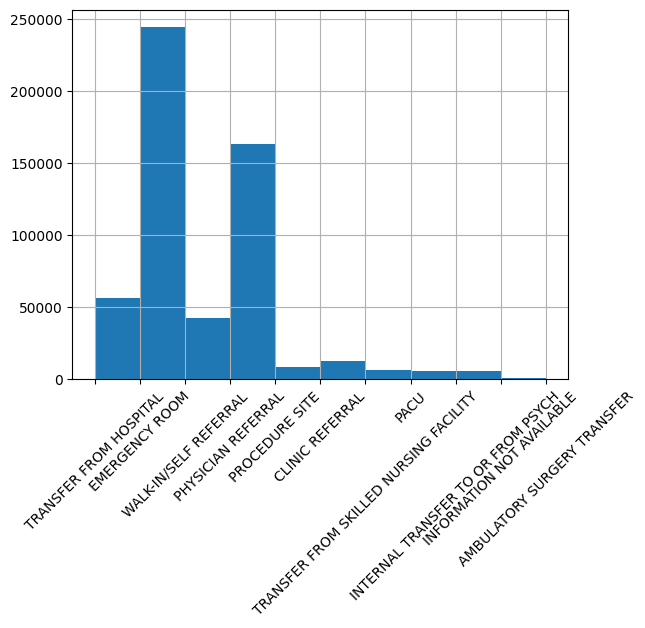

In [ ]:
import matplotlib.pyplot as plt

ad.admission_location.hist()
plt.xticks(rotation=45)

# add

In [ ]:
# defining outpatient as someone who checks themselves in
#ad_out = ad[ad.admission_location == 'WALK-IN/SELF REFERRAL']

# select needed variables
ad_out = ad[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'insurance', 'language', 'marital_status', 'race']]

# fix date data types to date without time
ad_out['admittime'] = pd.to_datetime(ad_out['admittime'])#.dt.date
ad_out['dischtime'] = pd.to_datetime(ad_out['dischtime'])#.dt.date

# add patient's last admission time before admittime
#ad_out['last_admittime'] = ad_out.sort_values(by='admittime').groupby('subject_id')['admittime'].shift(1)

print(ad_out.shape)
ad_out.head()

(546028, 8)


<ipython-input-158-10314166139d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_out['admittime'] = pd.to_datetime(ad_out['admittime'])#.dt.date
<ipython-input-158-10314166139d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_out['dischtime'] = pd.to_datetime(ad_out['dischtime'])#.dt.date


,subject_id,hadm_id,admittime,dischtime,insurance,language,marital_status,race
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,Medicaid,English,WIDOWED,WHITE
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,Medicaid,English,WIDOWED,WHITE
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,Medicaid,English,WIDOWED,WHITE
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,Medicaid,English,WIDOWED,WHITE
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,English,SINGLE,WHITE


In [ ]:
# merge ad_out and omr_pt on subject id
omr_pt_ad = ad_out.merge(omr_pt, on=['subject_id'], how='left')

# set omer_pt datetime
omr_pt_ad['chartdate'] = pd.to_datetime(omr_pt_ad['chartdate'])

# filter such that admittime - chartdate < 365 days
omr_pt_ad = omr_pt_ad[((omr_pt_ad['admittime'] - omr_pt_ad['chartdate']).dt.days <= 365)]

# drop dod
omr_pt_ad.drop(columns=['dod', 'chartdate'], inplace=True)

# map gender column to numeric
omr_pt_ad['gender'] = omr_pt_ad['gender'].map({'F': 0, 'M': 1})

# average multiple columns and groupby
omr_pt_ad = omr_pt_ad.groupby(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'insurance',
       'language', 'marital_status', 'race']).mean().reset_index()

# map gender column to F M
omr_pt_ad['gender'] = omr_pt_ad['gender'].map({0: 'F', 1: 'M'})

omr_pt_ad.head()

<ipython-input-159-3aff7f2aab0c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_pt_ad.drop(columns=['dod', 'chartdate'], inplace=True)


,subject_id,hadm_id,admittime,dischtime,insurance,language,marital_status,race,Height (Inches),Weight (Lbs),bp_systolic,bp_diastolic,gender,anchor_age
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,Medicaid,English,WIDOWED,WHITE,60.000,94.800,106.167,64.667,F,52.000
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,Medicaid,English,WIDOWED,WHITE,60.000,94.800,106.167,64.667,F,52.000
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,Medicaid,English,WIDOWED,WHITE,60.000,94.800,106.167,64.667,F,52.000
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,Medicaid,English,WIDOWED,WHITE,60.000,94.800,106.167,64.667,F,52.000
4,10000635,26134563,2136-06-19 14:24:00,2136-06-20 11:30:00,Medicare,English,WIDOWED,BLACK/AFRICAN AMERICAN,68.000,221.667,146.000,85.500,F,74.000


# Lab Events

# Old

In [ ]:
import pandas as pd

# get files
#files = [f for f in os.listdir('/content/drive/My Drive/Antibiotic Resistance Capstone Project/Data/MIMIC IV/mimic-iv-3.1/hosp')]

files = ['d_labitems.csv.gz',
 'd_hcpcs.csv.gz',
 'd_icd_diagnoses.csv.gz',
 'admissions.csv.gz',
 'diagnoses_icd.csv.gz',
 'emar.csv.gz',
 'emar_detail.csv.gz',
 'labevents.csv.gz',
 'microbiologyevents.csv.gz',
 'omr.csv.gz']

In [ ]:
data = {}
table_names = []
size = 10000
for f in files:
    tab_name = f.split('.')[0]

    df = pd.read_csv(f"/content/drive/My Drive/Antibiotic Resistance Capstone Project/Data/MIMIC IV/mimic-iv-3.1/hosp/{f}",
                     nrows=size,            # Size of file chunks to read at once
                     compression='gzip')

    data[tab_name] = df

In [ ]:
ad = data['admissions']
ad.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [ ]:
mb = data['microbiologyevents']
mb.head()

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,...,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments
0,1,10000032,NaN,1304715,P69FQC,2180-03-23 00:00:00,2180-03-23 11:51:00,70046,IMMUNOLOGY,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,___
1,2,10000032,NaN,3342526,P69FQC,2180-03-23 00:00:00,2180-03-23 11:51:00,70093,Blood (Toxo),1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEGATIVE FOR TOXOPLASMA IgG ANTIBODY BY EIA. ...
2,3,10000032,NaN,3910370,P69FQC,2180-03-23 00:00:00,2180-03-23 11:51:00,70017,SEROLOGY/BLOOD,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONREACTIVE. Reference Range: Non-Reactive.
3,4,10000032,NaN,5401234,P69FQC,2180-03-23 00:00:00,2180-03-23 11:51:00,70017,SEROLOGY/BLOOD,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POSITIVE BY EIA. A positive IgG result genera...
4,5,10000032,NaN,6287540,P69FQC,2180-03-23 00:00:00,2180-03-23 11:51:00,70046,IMMUNOLOGY,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIV-1 RNA is not detected. Performed using th...


# Old Code

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

# create 9 to 10 mapping
vten = diag_codes[diag_codes.icd_version == 10]
# join all long titles for each broad code
vten = vten[['icd_code_broad', 'long_title']].groupby('icd_code_broad').agg(' '.join).reset_index()

# remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
vten['long_title'] = vten['long_title'].apply(lambda x: tokenizer.tokenize(x))

# remove stop words from long title
vten['long_title'] = vten['long_title'].apply(lambda x: ' '.join([word.lower() for word in x if word.lower() not in stop_words and len(word) > 1]))

# most common word
vten['most_common'] = vten.long_title.apply(lambda x: Counter(x.split()).most_common(1)[0][0])

# group by most common words and select single code - code to use as feature
final_codes = vten.groupby(['most_common']).first().reset_index()
final_codes.rename(columns={'icd_code_broad': 'icd_code_final'}, inplace=True)

# join vten to vten_map on most_common and next_most_common - mapping for all vten codes
vten_map = final_codes.merge(vten[['most_common', 'icd_code_broad']], on=['most_common'], how='left')
vten_map.rename(columns={'icd_code_broad': 'vten_icd_code'}, inplace=True)

# get versin 9 list
vnin = diag_codes[diag_codes.icd_version == 9][['icd_code_broad', 'long_title']]
# select first 5 words of each long title
vnin['long_title'] = vnin['long_title'].apply(lambda x: ' '.join(x.split()[:5]))
# join all long titles for each broad code
vnin = vnin[['icd_code_broad', 'long_title']].groupby('icd_code_broad').agg(' '.join).reset_index()

# remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
vnin['long_title'] = vnin['long_title'].apply(lambda x: tokenizer.tokenize(x))

# remove stop words from long title
vnin['long_title'] = vnin['long_title'].apply(lambda x: ' '.join([word.lower() for word in x if word.lower() not in stop_words and len(word) > 1]))

# most common word
vnin['most_common'] = vnin.long_title.apply(lambda x: Counter(x.split()).most_common(1)[0][0])

# get exact matches - 762/1042 - 73%
vnin_map1 = final_codes.merge(vnin[['most_common', 'icd_code_broad']], on=['most_common'], how='inner')
vnin_map1.rename(columns={'icd_code_broad': 'vnin_icd_code'}, inplace=True)

# remove rows that have been matched from vnin
vnin_left = vnin[~vnin.icd_code_broad.isin(vnin_map1.vnin_icd_code)]['icd_code_broad'].reset_index()
vnin_left['most_common'] = 'unmapped'
vnin_left['icd_code_final'] = '999'
vnin_left['long_title'] = 'unmapped'
vnin_left = vnin_left[['most_common', 'icd_code_final', 'long_title', 'icd_code_broad']]
vnin_left.rename(columns={'icd_code_broad':'vnin_icd_code'}, inplace=True)

# concat with mapping
vnin_map = pd.concat([vnin_map1, vnin_left], axis=0)
vnin_map.rename(columns={'vnin_icd_code':'vten_icd_code'}, inplace=True)

# combine 9 and 10 mappings
code_map = pd.concat([vnin_map, vten_map], axis=0)
code_map

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,most_common,icd_code_final,long_title,vten_icd_code
0,abdominal,K45,abdominal hernia specified abdominal hernia ob...,789
1,abnormal,O02,abnormal products conception blighted ovum non...,631
2,abnormal,O02,abnormal products conception blighted ovum non...,781
3,abnormal,O02,abnormal products conception blighted ovum non...,790
4,abnormal,O02,abnormal products conception blighted ovum non...,793
...,...,...,...,...
1909,wrist,S69,unspecified injuries wrist hand finger specifi...,S69
1910,yaws,A66,yaws initial lesions yaws multiple papillomata...,A66
1911,yellow,A95,yellow fever sylvatic yellow fever urban yello...,A95
1912,zoonotic,A28,zoonotic bacterial diseases elsewhere classifi...,A28


In [ ]:
# match non-matched based on first 3 digits
non_matched = diag_mapped[diag_mapped.ccsr_category.isna()]
non_matched = non_matched.loc[:, 'subject_id':'dischtime']
icd_code_mapping['icd9_broad'] = icd_code_mapping['icd9cm'].str[:5]
icd_code_mapping['icd10_broad'] = icd_code_mapping['icd10cm'].str[:5]
non_matched['broad_code'] = non_matched['icd_code'].str[:5]

non_matched9 = non_matched[non_matched['icd_version'] == 9].merge(icd_code_mapping, left_on='broad_code', right_on='icd9_broad', how='left')
non_matched10 = non_matched[non_matched['icd_version'] == 10].merge(icd_code_mapping, left_on='broad_code', right_on='icd10_broad', how='left')
non_matched_mapped = pd.concat([non_matched9, non_matched10], axis=0).drop_duplicates()
non_matched_mapped.drop(columns=['broad_code', 'icd9_broad', 'icd10_broad'], inplace=True)